### <center> **PROJECT-3. Анализ воронки**
Выполнил: Игошин Даниил Дмитриевич

### <center> **ЗАДАЧИ**

1.Определить, насколько обучение сокращает время прохождения этапов игры.

2.Проверить, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.

3.Определить, насколько прозрачен процесс взаимодействия с игрой.


*Для начала приведем данные к работоспособному виду:*

In [253]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


events=pd.read_csv('project#3/Events.csv')                #Чтение файла Events.csv
events['start_time']=pd.to_datetime(events['start_time']) #Перевод даты в формат DateTime
events_1=events.copy()                                    #Создаем копию

purchase = pd.read_csv('project#3/Purchase.csv')                      #Чтение файла Purchase.csv
purchase['event_datetime']=pd.to_datetime(purchase['event_datetime']) #Перевод даты в формат DateTime
purchase['year'] = purchase['event_datetime'].dt.year                 #Создание столбца с годом 
purchase_df = purchase.copy()                                         #Создаем копию

#Создаем маску, которая отфильтрует данные по 2018 году
mask_1 = events_1['start_time'] < '2019-01-01'
mask_2 = events_1['start_time'] >= '2018-01-01'
mask_3 = events_1['event_type'] == 'registration'
events_mask2018 = events_1[mask_1 & mask_2 & mask_3]

# Определяем список пользователей, которые зарегистрировались в 2018 году
user_list = events_mask2018['user_id']

# Фильтруем данные в таблице events_df на основе списка пользователей
events_df = events_1[events_1['user_id'].isin(user_list)]

# Фильтруем данные в тблице purchase_df на основе списка пользователей
purchase_df = purchase_df[purchase_df['user_id'].isin(user_list)]

# Добавление, переименование столбцов
purchase_df['event_type'] = 'purchase'
events_df = events_df.rename(columns ={'id':'event_id'})
purchase_df = purchase_df.rename(columns={"id": "purchase_id", "event_datetime": "start_time"})

# Объединим датафреймы events_df и purchase_df с помощью функции pd.concat()
total_events_df = pd.concat([events_df,purchase_df],sort=False)

# Сбросим индексы и отсортируем по времени события
total_events_df = total_events_df.reset_index(drop=True).sort_values('start_time') 

### *Задача №1*

In [254]:
#создаем сводную таблицу 
pivot_df = total_events_df.pivot_table(
    values= 'start_time',
    index= 'user_id',
    columns= 'event_type',
    aggfunc = 'min'
)

#создаем списки пользователей, закончивших и не начавших обучение. Это понадобится для функции распределения
set_users_with_tutorial_finish = set(total_events_df[total_events_df['event_type']=='tutorial_finish']['user_id'])
set_users_without_tutorial_start = set(total_events_df[total_events_df['event_type']!='tutorial_start']['user_id'])

# Функция для распределения пользователей по группам. Она проверяет вхождение в раннее создынные множества пользователей и при совпадении выносит прописанный результат
def get_tutorial_status(x):
    if x in set_users_with_tutorial_finish:
        return 'закончил обучение'
    elif x in set_users_without_tutorial_start:
        return 'не начинал обучение'
    else:
        return 'не закончил обучение'

# Применим функцию к сводной таблице
pivot_df.replace(np.NaN, pd.NaT, inplace=True)
pivot_df = pivot_df.reset_index()
pivot_df['tutorial_status'] = pivot_df['user_id'].apply(get_tutorial_status)

#посчитаем разницу во времени между разными событиями
pivot_df['purchase-registration'] = (pivot_df['purchase']-pivot_df['registration'])/pd.Timedelta('1 hour')
pivot_df['purchase-pack_choice'] = (pivot_df['purchase']-pivot_df['pack_choice'])/pd.Timedelta('1 hour')
pivot_df['level_choice-registration'] = (pivot_df['level_choice']-pivot_df['registration'])/pd.Timedelta('1 hour')
pivot_df['pack_choice-level_choice'] = (pivot_df['pack_choice']-pivot_df['level_choice'])/pd.Timedelta('1 hour')
pivot_df['tutorial_finish-tutorial_start'] = (pivot_df['tutorial_finish']-pivot_df['tutorial_start'])/pd.Timedelta('1 hour')
pivot_df['tutorial_start-registration'] = (pivot_df['tutorial_start']-pivot_df['registration'])/pd.Timedelta('1 hour')

#создаем результирующую переменную с помощью функции group_by, так как именно эта функция может сделать группировку по выбранному столбцу
result =(pivot_df.groupby(by = 'tutorial_status')[['purchase-registration',
                                                  'purchase-pack_choice',
                                                  'level_choice-registration',
                                                  'pack_choice-level_choice',
                                                  'tutorial_finish-tutorial_start',
                                                  'tutorial_start-registration']].mean())

#переименуем столбцы для большего понимания
result = result.rename(columns ={'purchase-registration':'Покупка-регистрация',
                                 'purchase-pack_choice':'Покупка-выбор вопросов',
                                "level_choice-registration":'выбор уровня сложности-регистрация',
                                'pack_choice-level_choice':'выбор пакета вопросов-выбор уровня сложности',
                                'tutorial_finish-tutorial_start':'завершенное обучение-начатое обучение',
                                'tutorial_start-registration':'начатое обучение-регистрация'})

### *Задача №2*

In [255]:
#создаем фильтрующую маску, которая оставит тип события tutorial_start и tutorial_finish
mask = (total_events_df["event_type"] == "tutorial_start") | (total_events_df["event_type"] == "tutorial_finish") 
group_by = total_events_df[mask][['user_id','event_type','start_time']]

#создаем сводную таблицу для подсчета количества начатых и пройденных обучений
group_by = group_by.pivot_table(values = 'start_time', 
                                index = 'user_id', 
                                columns = 'event_type', 
                                aggfunc= 'count').reset_index()

#создаем множества для определения пользователей, которые совершали и не совершали покупки
set_purchase = set(total_events_df[total_events_df['purchase_id']>0]['user_id'])
set_purchase_without = total_events_df.fillna(0)
set_purchase_without = set(set_purchase_without[set_purchase_without['purchase_id']==0]['user_id'])

#функция, дающая статус клиенту. Находит вхождение в раннее созданные множества
def get_purchase_status(x):
    if x in set_purchase:
        return 'совершил покупку'
    elif x in set_purchase_without:
        return 'не совершил покупку'

#применяем функцию к сводой твблице
group_by['pucrhase_status'] = group_by['user_id'].apply(get_purchase_status)

#группируем значения по кол-ву начатых и законченых обучений и находим кол-во совершеных покупок
group_by_tutor_start = ((group_by[group_by['pucrhase_status']=='совершил покупку'].groupby(by ='tutorial_start')['pucrhase_status'].count()).reset_index())
group_by_tutor_start['percent'] = (group_by_tutor_start['pucrhase_status']/(group_by_tutor_start['pucrhase_status'].sum()/100)).round()
group_by_tutor_start = group_by_tutor_start.rename(columns ={'tutorial_start':'Кол-во начатых обучений',
                                                   'pucrhase_status':'Кол-во покупок',
                                                    'percent':'Процент от кол-ва покупок'}
)

group_by_tutor_finish = ((group_by[group_by['pucrhase_status']=='совершил покупку'].groupby(by ='tutorial_finish')['pucrhase_status'].count()).reset_index())
group_by_tutor_finish['percent'] = (group_by_tutor_finish['pucrhase_status']/(group_by_tutor_finish['pucrhase_status'].sum()/100)).round()
group_by_tutor_finish = group_by_tutor_finish.rename(columns ={'tutorial_finish':'Кол-во пройденных обучений',
                                                   'pucrhase_status':'Кол-во покупок',
                                                    'percent':'Процент от кол-ва покупок'})

### *Задача №3*

In [256]:
#создаем маску, фильтрующую столбец события на tutorial_start и level_choice
maskk_1 = (total_events_df["event_type"] == "tutorial_start") | (total_events_df["event_type"] == "level_choice") 
hypothesis_3 = total_events_df[maskk_1]

#создаем множество из пользователей, выбиравших уровень сложности
level_choice_set = set(total_events_df[total_events_df['event_type']=='level_choice']['user_id'])

#фильтруем пользователей по этому множеству 
hypothesis_3 = hypothesis_3[hypothesis_3['user_id'].isin(level_choice_set)]

#создаем сводную таблицу
hypothesis_3 = hypothesis_3.pivot_table(values = 'start_time', index = 'user_id', columns = 'event_type').reset_index()
hypothesis_3['dif'] = hypothesis_3['level_choice'] - hypothesis_3['tutorial_start']
hypothesis_3['dif'] = hypothesis_3['dif'].dt.days

#создаем множество из пользователей, которые начали событе tutorial_start после level_choice
set_users = set(hypothesis_3[hypothesis_3['dif']<0]['user_id'])

#создаем функцию, дающую статус пользователям, которые начали обучение после выбора уровня сложности
def status(x):
    if x in set_users:
        return 'начал обучение после выбора сложности'
    else:
        return 'не начинал обучение после выбора сложности'

#применяем функцию к сводной таблийе
hypothesis_3['status'] = hypothesis_3['user_id'].apply(status)

#группируем пользователей по статусу и находим кол-во каждой группы
hypothesis_3 = hypothesis_3.groupby(by = 'status')['user_id'].count().reset_index()

#считаем процент каждой группы п формуле: кол-во пользователей в группе/(Кол-во пользоваталей/100)
hypothesis_3['percent'] = (hypothesis_3['user_id']/(hypothesis_3['user_id'].sum()/100)).round()

#переименуем столбцы для большего понимания
hypothesis_3 = hypothesis_3.rename(columns={'status' : 'Статус', 'user_id' : 'Кол-во пользователей', 'percent' : 'процент пользователей'})

# <center> **Выводы**

### *Задача № 1*

event_type,tutorial_status,Покупка-регистрация,Покупка-выбор вопросов,выбор уровня сложности-регистрация,выбор пакета вопросов-выбор уровня сложности,завершенное обучение-начатое обучение,начатое обучение-регистрация
0,закончил обучение,96.500902,89.299900,7.093571,0.088374,0.20384,4.518038
1,не начинал обучение,102.058920,94.336245,7.871438,0.085483,NaN,5.417470


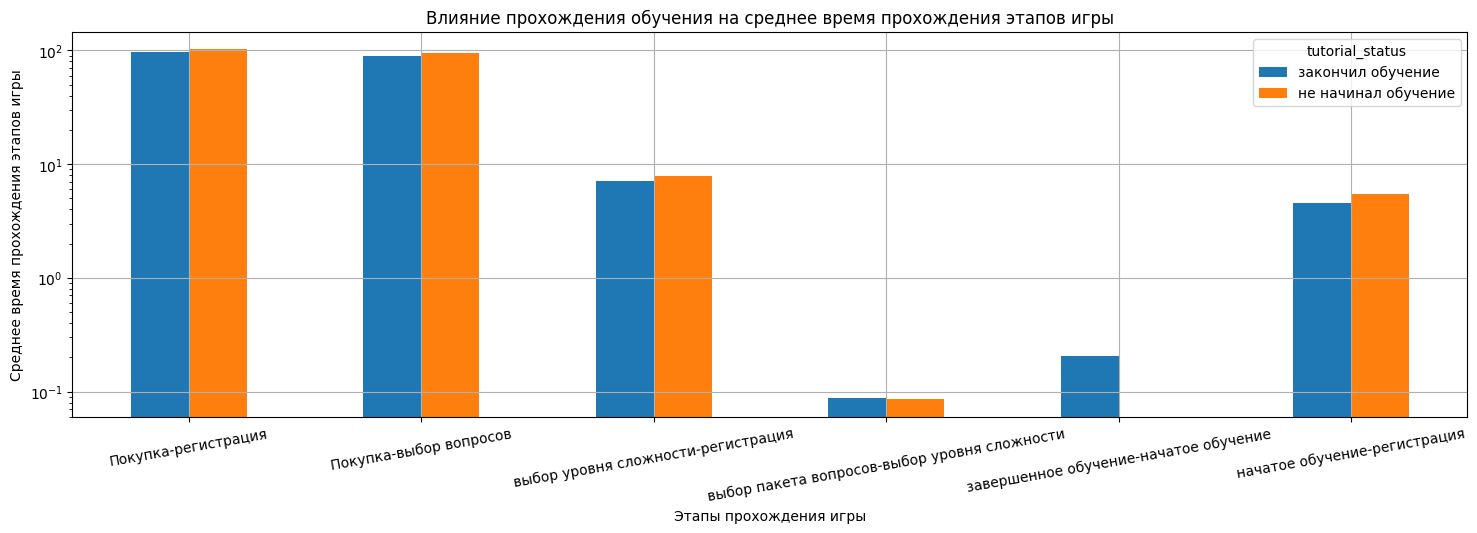

In [257]:
#Создание столбчатой диаграммы по первой гипотезе
result_new = result.T

ax = result_new.plot(
    kind='bar',
    grid=True,
    figsize=(18,5),
    title='Влияние прохождения обучения на среднее время прохождения этапов игры',
    xlabel='Этапы прохождения игры',
    ylabel='Среднее время прохождения этапов игры',
    rot=10
    )
ax.set_yscale('log')

display((result.reset_index()))

***Вывод:***

Как можно заметить, время прохождения этапов действительно зависит от пройденного обучения. Синими столбцами являются показатели пользователей, которые закончили обучениие, что говорит о том, что ***пройденное обучение сокращает время прохождения этапов игры***

### *Задача № 2*

,Кол-во начатых обучений,Кол-во покупок,Процент от кол-ва покупок
0,1.0,1207,76.0
1,2.0,218,14.0
2,3.0,51,3.0
3,4.0,30,2.0
4,5.0,16,1.0
5,6.0,14,1.0
6,7.0,12,1.0
7,8.0,13,1.0
8,9.0,17,1.0


,Кол-во пройденных обучений,Кол-во покупок,Процент от кол-ва покупок
0,1.0,1143,79.0
1,2.0,182,13.0
2,3.0,44,3.0
3,4.0,19,1.0
4,5.0,19,1.0
5,6.0,15,1.0
6,7.0,15,1.0
7,8.0,6,0.0
8,9.0,4,0.0


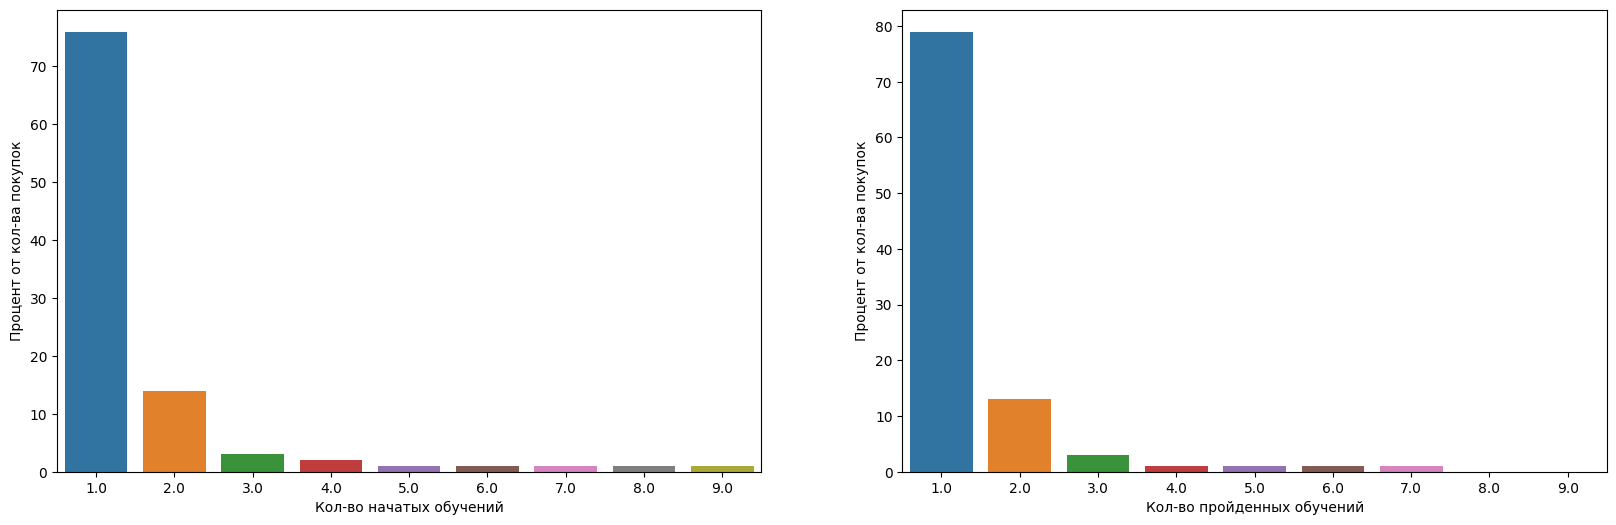

In [258]:
#Создание столбчатой диаграммы по второй гипотезе
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
barplot_tutor_start = sns.barplot(
    data=group_by_tutor_start,
    x='Кол-во начатых обучений',
    y='Процент от кол-ва покупок',
    orient='v',
    ax = axes[0]
)

barplot_tutor_finish = sns.barplot(
    data=group_by_tutor_finish,
    x='Кол-во пройденных обучений',
    y='Процент от кол-ва покупок',
    orient='v',
    ax = axes[1]
)
display(group_by_tutor_start,group_by_tutor_finish)

***Вывод:***

По результатам видно, что кол-во начатых и пройденных обучений зависит на покупку таким образом, что ***при повторном прохождении*** этого этапа ***вероятность покупки уменьшается***. Следовательно следовало бы постараться ***сделать обучение более информативным***, чтобы пользователи к нему не возвращались. 

### *Задача№ 3* 

In [259]:
display(hypothesis_3)

,Статус,Кол-во пользователей,процент пользователей
0,начал обучение после выбора сложности,946,11.0
1,не начинал обучение после выбора сложности,7396,89.0


***Вывод***

В результате подсчета ***11%*** пользователей ***начинали обучение после выбора уровня сложности***. Это может говорить о том, что работа с сервисом недостаточно понятна и следовало бы сделать обучение более информативным или упростить какие то этапы.